In [303]:
import warnings
warnings.filterwarnings("ignore")

In [304]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
from pykalman import KalmanFilter
import statsmodels.api as sm
from arch.unitroot import ADF
import yfinance as yf

trans_cov = 1e-5 / (1 - 1e-5) * np.eye(2)
threshold = 1.96

def adfTest(series):
    adfT = ADF(series)
    if adfT.pvalue > 0.05:
        return False, adfT.pvalue
    return True, adfT.pvalue

def visualize(data, symbols):
    plt.figure(figsize=(15, 7))
    for syl in symbols:
        data[syl].plot(label=syl)
    plt.legend()
    plt.ylabel('Adjusted YTM')
    plt.show()
    print("Successfully Plot YTM")

def spread(X, Y):
    sp = Y - X
    print(sp)
    if not adfTest(sp)[0]:
        print("Spread is not stationary. P value of ADF test is", adfTest(sp)[1])
    else:
        print('''
            Spread is stationary
            P value of ADF test: %f
            ''' % (adfTest(spread)[1]))
    return sp
    
def cointegration(X, Y):
    results = sm.OLS(Y, sm.add_constant(X)).fit()
    resid = results.resid
    if not adfTest(resid)[0]:
        print("X and Y are not cointegrated. P value of ADF test is", adfTest(resid)[1])
        return None
    else:
        print('''
        X and Y are cointegrated
        P value of ADF test: %f
        Intercept: %f
        Beta: %f
        ''' % (adfTest(resid)[1], results.params[0], results.params[1]))
        return results.params[0], results.params[1]

def kalman_filter(data, symbols, trans_cov):
    obs_mat = sm.add_constant(data[symbols[0]].values, prepend=False)[:, np.newaxis]

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2,
                      initial_state_mean=np.ones(2),
                      initial_state_covariance=np.ones((2, 2)),
                      transition_matrices=np.eye(2),
                      observation_matrices=obs_mat,
                      observation_covariance=0.5,
                      transition_covariance=trans_cov)
    state_means, state_covs = kf.filter(data[symbols[1]].values)
    slope=state_means[:, 0]
    intercept=state_means[:, 1]
    plt.figure(figsize =(15,7))
    plt.plot(data[symbols[1]].index, slope, c='b')
    plt.ylabel('slope')
    plt.title('kf updating slope')
    
    plt.figure(figsize =(15,7))
    plt.plot(data[symbols[1]].index,intercept,c='r')
    plt.ylabel('intercept')
    plt.title('kf updating intercept')
    plt.show()

    kl_spread = data[symbols[1]] - data[symbols[0]] * state_means[:, 0] - state_means[:, 1]
    return kl_spread, slope

def set_signal(data, threshold, symbols):
    fig, ax = plt.subplots(2, 1, figsize=(15, 8))
    df = pd.DataFrame()
    count = 0
    titles = ["Fixed Beta", "Kalman Filter"]

    for sym in symbols:
        mean, lower, upper, buy, sell, close_pos = "mean_"+sym, "lower_"+sym, "upper_"+sym, "buy_"+sym, "sell_"+sym, "close_pos_"+sym

        df['spread'] = data[sym]
        df[mean] = df['spread'].mean()
        mu = df[mean]
        sigma = df['spread'].std()
        df[upper] = mu + threshold * sigma
        df[lower] = mu - threshold * sigma

        df[buy] = df['spread'][((df['spread'] < df[lower]) & (df['spread'].shift(1) >= df[lower])) | 
                                ((df['spread'] < df[upper]) & (df['spread'].shift(1) >= df[upper]))]
        # df[close_pos] = df['spread'][((df['spread'] > lower) & (df['spread'].shift(1) <= lower)) | 
        #                             ((df['spread'] < upper) & (df['spread'].shift(1) >= upper))]
        df[sell] = df['spread'][((df['spread'] > df[upper]) & (df['spread'].shift(1) <= df[upper])) |
                                ((df['spread'] > df[lower]) & (df['spread'].shift(1) <= df[lower]))]

        pic = ax[count]
        pic.plot(df['spread'], 'g')
        pic.plot(df[mean],'--r', label=mean)
        pic.plot(df[upper], '--b', label=upper)
        pic.plot(df[lower], '--b', label=lower)
        pic.plot(df[buy], 'm^', label=buy)
        pic.plot(df[sell], 'cv', label=sell)

        pic.set_title(titles[count])
        pic.set_xlabel('Time')
        pic.set_ylabel('YTM' + titles[count])
        pic.legend()

        count+=1

    return df
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

    

    print("Success!")

                                 AAPL        MSFT
Date                                             
2019-10-01 00:00:00-04:00   54.330788  130.922424
2019-10-02 00:00:00-04:00   52.968830  128.610901
2019-10-03 00:00:00-04:00   53.418793  130.167816
2019-10-04 00:00:00-04:00   54.916203  131.925308
2019-10-07 00:00:00-04:00   54.928318  130.970154
...                               ...         ...
2023-09-25 00:00:00-04:00  175.183578  315.174286
2023-09-26 00:00:00-04:00  171.084549  309.814514
2023-09-27 00:00:00-04:00  169.562317  310.459686
2023-09-28 00:00:00-04:00  169.821014  311.303375
2023-09-29 00:00:00-04:00  170.338364  313.397583

[1007 rows x 2 columns]


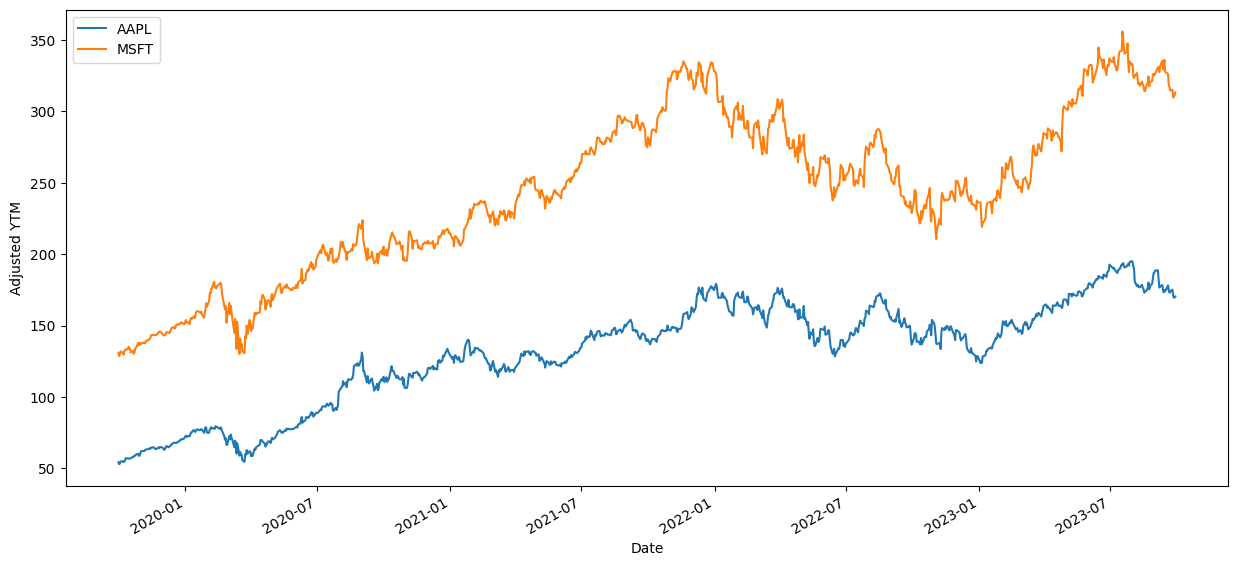

Successfully Plot YTM


In [305]:
AAPL = yf.Ticker("AAPL")
MSFT = yf.Ticker("MSFT")
hist = pd.DataFrame()
start_date = "2019-10-01"
end_date = "2023-10-01"
hist['AAPL'] = pd.DataFrame(AAPL.history(start=start_date, end=end_date)['Close'])
hist['MSFT'] = pd.DataFrame(MSFT.history(start=start_date, end=end_date)['Close'])
hist.dropna(axis = 0, inplace = True)
print(hist)
syms = ['AAPL', 'MSFT']
visualize(hist, syms)


Date
2019-10-01 00:00:00-04:00     76.591637
2019-10-02 00:00:00-04:00     75.642071
2019-10-03 00:00:00-04:00     76.749023
2019-10-04 00:00:00-04:00     77.009106
2019-10-07 00:00:00-04:00     76.041836
                                ...    
2023-09-25 00:00:00-04:00    139.990707
2023-09-26 00:00:00-04:00    138.729965
2023-09-27 00:00:00-04:00    140.897369
2023-09-28 00:00:00-04:00    141.482361
2023-09-29 00:00:00-04:00    143.059219
Length: 1007, dtype: float64
Spread is not stationary. P value of ADF test is 0.47005920127349243


<Axes: xlabel='Date'>

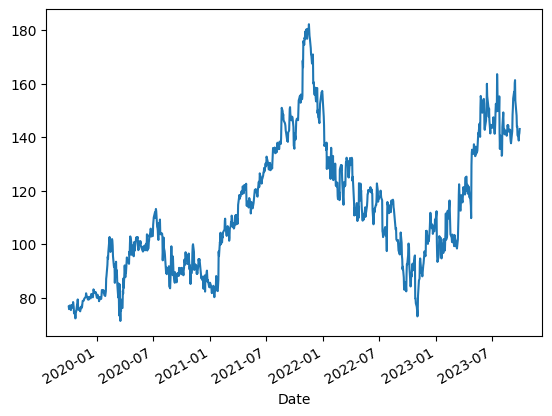

In [306]:
sp = spread(hist['AAPL'], hist['MSFT'])
sp.plot()

In [307]:
params = cointegration(hist['AAPL'], hist['MSFT'])
intercept = 0
beta = 0
if params is not None:
    intercept = params[0]
    beta = params[1]
res = pd.DataFrame()
coin_spread = hist['MSFT'] - intercept - beta*hist['AAPL']

X and Y are not cointegrated. P value of ADF test is 0.241260256872731


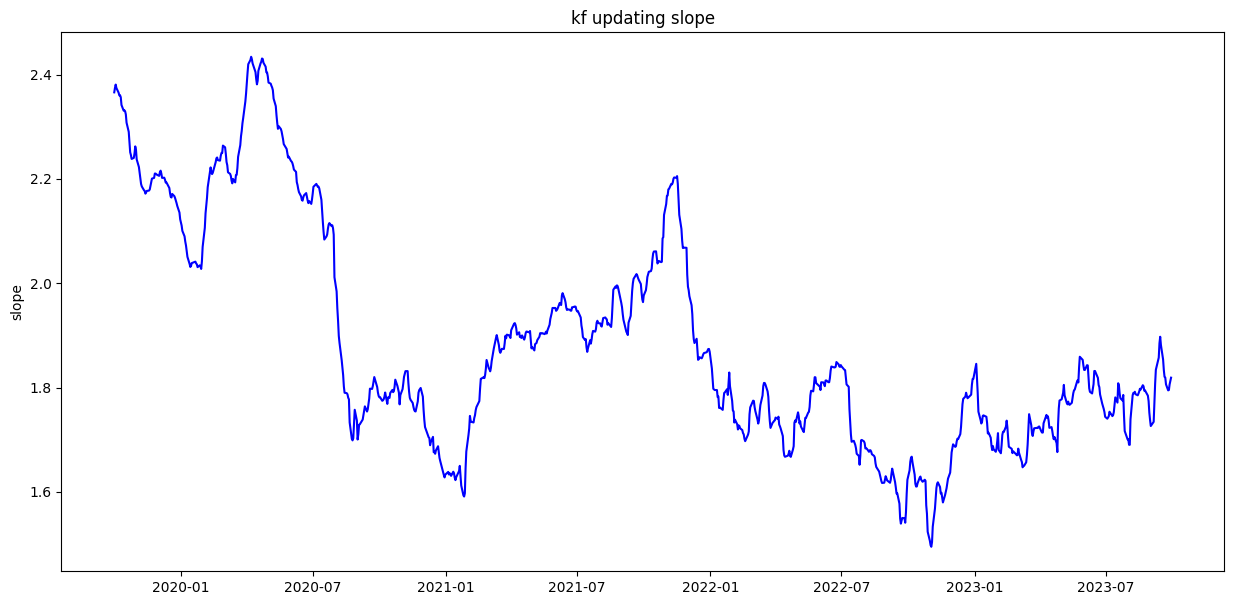

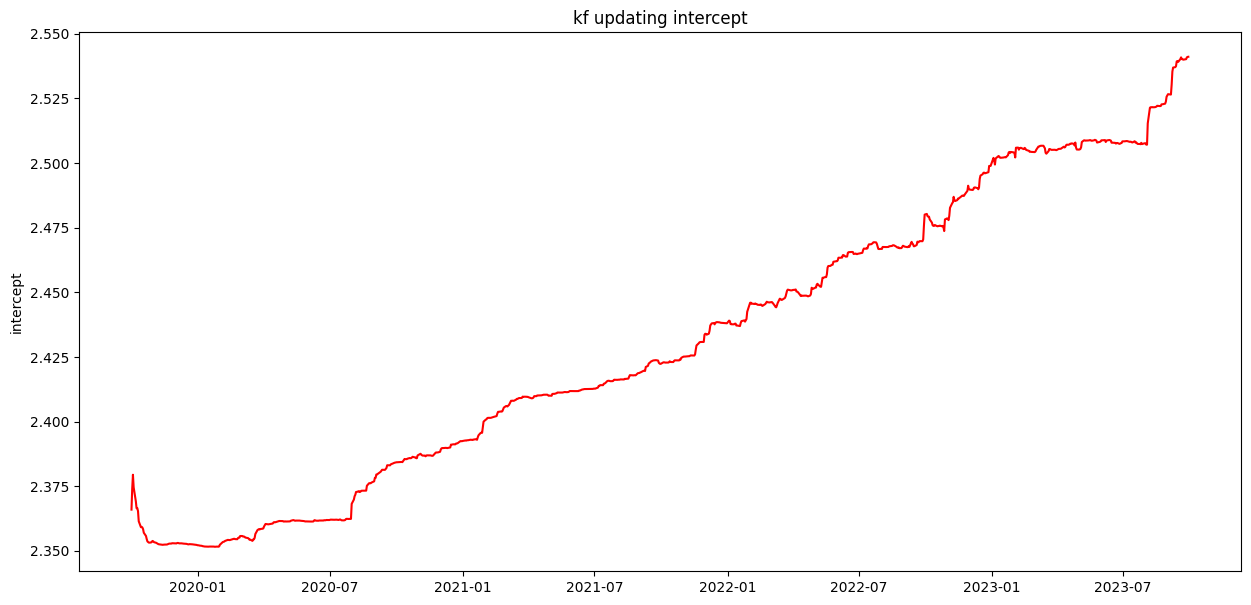

In [308]:
kf_spread, kf_beta = kalman_filter(hist, syms, trans_cov)

In [309]:
result = adfTest(kf_spread)
print(result)

(True, 5.4355269456891495e-11)


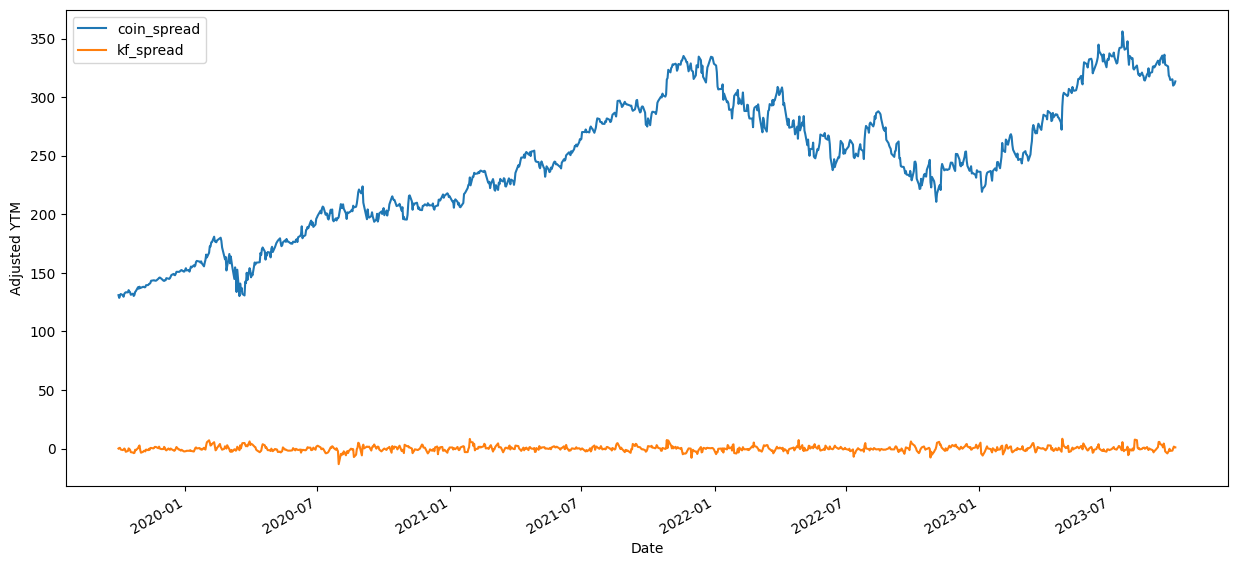

Successfully Plot YTM


In [310]:
res['coin_spread'], res['kf_spread'] = coin_spread, kf_spread
spread_syms = ["coin_spread", "kf_spread"]
visualize(res, spread_syms)

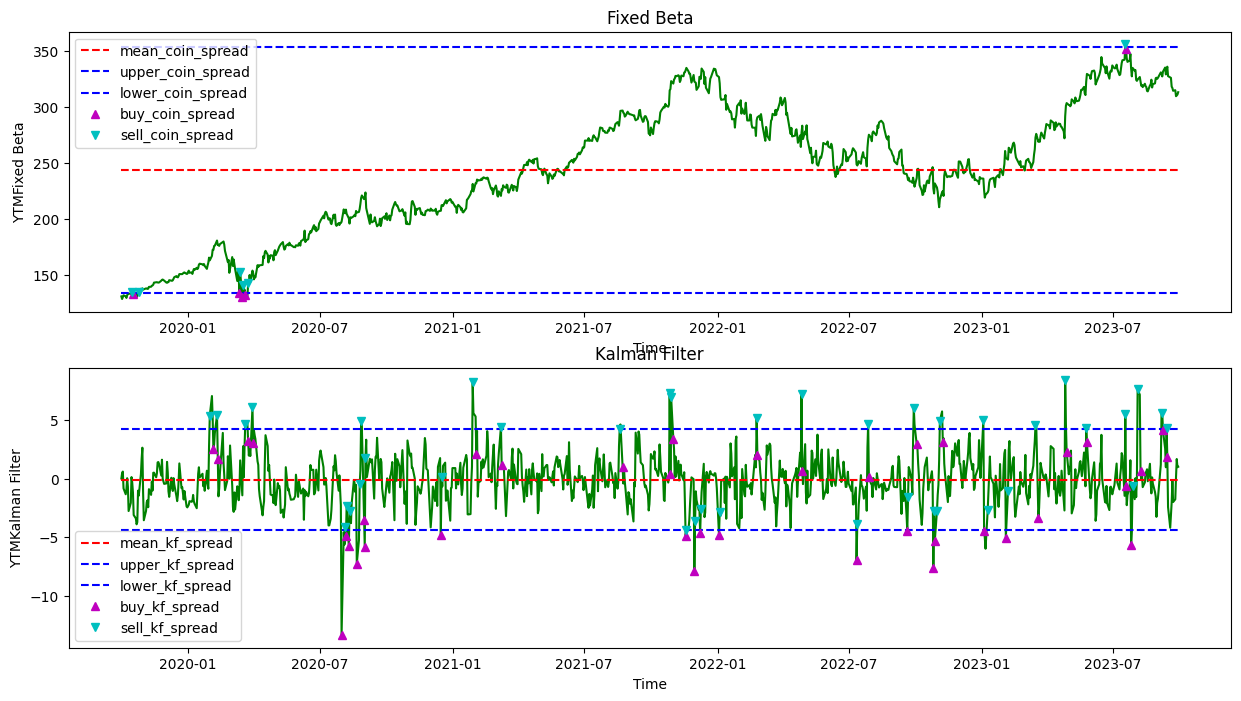

In [311]:
df = set_signal(res, threshold, spread_syms)

In [312]:
df = df.fillna(1000)
df.head()

,spread,mean_coin_spread,upper_coin_spread,lower_coin_spread,buy_coin_spread,sell_coin_spread,mean_kf_spread,upper_kf_spread,lower_kf_spread,buy_kf_spread,sell_kf_spread
Date,,,,,,,,,,,
2019-10-01 00:00:00-04:00,0.012344,243.706256,353.667603,133.744909,1000.0,1000.0,-0.078056,4.198525,-4.354636,1000.0,1000.0
2019-10-02 00:00:00-04:00,0.459883,243.706256,353.667603,133.744909,1000.0,1000.0,-0.078056,4.198525,-4.354636,1000.0,1000.0
2019-10-03 00:00:00-04:00,0.605066,243.706256,353.667603,133.744909,1000.0,1000.0,-0.078056,4.198525,-4.354636,1000.0,1000.0
2019-10-04 00:00:00-04:00,-0.833644,243.706256,353.667603,133.744909,1000.0,1000.0,-0.078056,4.198525,-4.354636,1000.0,1000.0
2019-10-07 00:00:00-04:00,-1.329322,243.706256,353.667603,133.744909,1000.0,1000.0,-0.078056,4.198525,-4.354636,1000.0,1000.0


# Spread Cointegration Type of Signals (Not working for not passing stationarity test)
## See {Kalman Filter} section below for reliable results

In [314]:
# Buy Spread: the signal says spread is undervalued (or return to normal band from being overvalued)
                        # so long the expensive (MSFT) and short the cheap (AAPL)
# Sell Spread: the signal says spread is overvalued (or return to normal band from being undervalued)
                        # so short the expensive (MSFT) and long the cheap (AAPL)
NAA = 1000.0
coin_spread_signals = df[["buy_coin_spread", "sell_coin_spread"]]
cs_MSFT = np.zeros(len(coin_spread_signals))
# cs_sell_MSFT = np.zeros(len(coin_spread_signals))
# cs_buy_AAPL = np.zeros(len(coin_spread_signals))
# cs_sell_AAPL = np.zeros(len(coin_spread_signals))
for t in coin_spread_signals.index:
    b = df.loc[t]["buy_coin_spread"]
    s = df.loc[t]["sell_coin_spread"]
    if (b != NAA) & (s == NAA):
        cs_MSFT[list(coin_spread_signals.index).index(t)] = 1
    if (b == NAA) & (s != NAA):
        cs_MSFT[list(coin_spread_signals.index).index(t)] = -1
cs_AAPL = cs_MSFT * (-1)

In [315]:
coin_spread_signals['cs_MSFT'] = cs_MSFT
coin_spread_signals['cs_AAPL'] = cs_AAPL

In [316]:
coin_spread_signals[coin_spread_signals["cs_MSFT"] != 0]

,buy_coin_spread,sell_coin_spread,cs_MSFT,cs_AAPL
Date,,,,
2019-10-15 00:00:00-04:00,1000.000000,135.220551,-1.0,1.0
2019-10-17 00:00:00-04:00,133.424911,1000.000000,1.0,-1.0
2019-10-25 00:00:00-04:00,1000.000000,134.418182,-1.0,1.0
2020-03-12 00:00:00-04:00,133.639145,1000.000000,1.0,-1.0
2020-03-13 00:00:00-04:00,1000.000000,152.638443,-1.0,1.0
2020-03-16 00:00:00-04:00,130.141006,1000.000000,1.0,-1.0
2020-03-17 00:00:00-04:00,1000.000000,140.856400,-1.0,1.0
2020-03-20 00:00:00-04:00,131.995789,1000.000000,1.0,-1.0
2020-03-24 00:00:00-04:00,1000.000000,142.557373,-1.0,1.0


In [317]:
coin_spread_signals['raw_MSFT'] = hist['MSFT']
coin_spread_signals['raw_AAPL'] = hist['AAPL']
coin_spread_signals.head()

,buy_coin_spread,sell_coin_spread,cs_MSFT,cs_AAPL,raw_MSFT,raw_AAPL
Date,,,,,,
2019-10-01 00:00:00-04:00,1000.0,1000.0,0.0,-0.0,130.922424,54.330788
2019-10-02 00:00:00-04:00,1000.0,1000.0,0.0,-0.0,128.610901,52.968830
2019-10-03 00:00:00-04:00,1000.0,1000.0,0.0,-0.0,130.167816,53.418793
2019-10-04 00:00:00-04:00,1000.0,1000.0,0.0,-0.0,131.925308,54.916203
2019-10-07 00:00:00-04:00,1000.0,1000.0,0.0,-0.0,130.970154,54.928318


# Kalman Filter Version of Signals

In [319]:
# Buy Spread: the signal says spread is undervalued (or return to normal band from being overvalued)
                        # so long the expensive (MSFT) and short the cheap (AAPL)
# Sell Spread: the signal says spread is overvalued (or return to normal band from being undervalued)
                        # so short the expensive (MSFT) and long the cheap (AAPL)
NAA = 1000.0
kf_signals = df[["buy_kf_spread", "sell_kf_spread"]]
kf_MSFT = np.zeros(len(kf_signals))
# cs_sell_MSFT = np.zeros(len(coin_spread_signals))
# cs_buy_AAPL = np.zeros(len(coin_spread_signals))
# cs_sell_AAPL = np.zeros(len(coin_spread_signals))
for t in kf_signals.index:
    b = df.loc[t]["buy_kf_spread"]
    s = df.loc[t]["sell_kf_spread"]
    if (b != NAA) & (s == NAA):
        kf_MSFT[list(kf_signals.index).index(t)] = 1
    if (b == NAA) & (s != NAA):
        kf_MSFT[list(kf_signals.index).index(t)] = -1
kf_AAPL = kf_MSFT * (-1)
kf_signals['kf_MSFT'] = kf_MSFT
kf_signals['kf_AAPL'] = kf_AAPL
kf_signals['raw_MSFT_kf'] = hist['MSFT']
kf_signals['raw_AAPL_kf'] = hist['AAPL']
kf_signals['beta'] = kf_beta

In [320]:
kf_signals.head()

,buy_kf_spread,sell_kf_spread,kf_MSFT,kf_AAPL,raw_MSFT_kf,raw_AAPL_kf,beta
Date,,,,,,,
2019-10-01 00:00:00-04:00,1000.0,1000.0,0.0,-0.0,130.922424,54.330788,2.365954
2019-10-02 00:00:00-04:00,1000.0,1000.0,0.0,-0.0,128.610901,52.968830,2.374546
2019-10-03 00:00:00-04:00,1000.0,1000.0,0.0,-0.0,130.167816,53.418793,2.380872
2019-10-04 00:00:00-04:00,1000.0,1000.0,0.0,-0.0,131.925308,54.916203,2.374242
2019-10-07 00:00:00-04:00,1000.0,1000.0,0.0,-0.0,130.970154,54.928318,2.365452


In [321]:
positions_AAPL = []
positions_MSFT = []

for i, row in kf_signals.iterrows():
    price_AAPL = row['raw_AAPL_kf']
    price_MSFT = row['raw_MSFT_kf']
    
    signal_AAPL = row['kf_AAPL']  # +1 for buy, -1 for sell, 0 for hold
    signal_MSFT = row['kf_MSFT']  
    
    beta = row['beta']
    
    # Define positions based on the beta
    if signal_MSFT != 0:
        position_MSFT = signal_MSFT * 100 # Assume we take 100 units of MSFT for each trade
        # Calculate the hedged position in Stock B using beta
        position_AAPL = -position_MSFT * beta  
        
    else:
        # If no trade signal, no position is taken
        position_AAPL = 0
        position_MSFT = 0
    
    positions_AAPL.append(position_AAPL)
    positions_MSFT.append(position_MSFT)

kf_signals['position_AAPL'] = positions_AAPL
kf_signals['position_MSFT'] = positions_MSFT

kf_signals.head()

,buy_kf_spread,sell_kf_spread,kf_MSFT,kf_AAPL,raw_MSFT_kf,raw_AAPL_kf,beta,position_AAPL,position_MSFT
Date,,,,,,,,,
2019-10-01 00:00:00-04:00,1000.0,1000.0,0.0,-0.0,130.922424,54.330788,2.365954,0.0,0.0
2019-10-02 00:00:00-04:00,1000.0,1000.0,0.0,-0.0,128.610901,52.968830,2.374546,0.0,0.0
2019-10-03 00:00:00-04:00,1000.0,1000.0,0.0,-0.0,130.167816,53.418793,2.380872,0.0,0.0
2019-10-04 00:00:00-04:00,1000.0,1000.0,0.0,-0.0,131.925308,54.916203,2.374242,0.0,0.0
2019-10-07 00:00:00-04:00,1000.0,1000.0,0.0,-0.0,130.970154,54.928318,2.365452,0.0,0.0


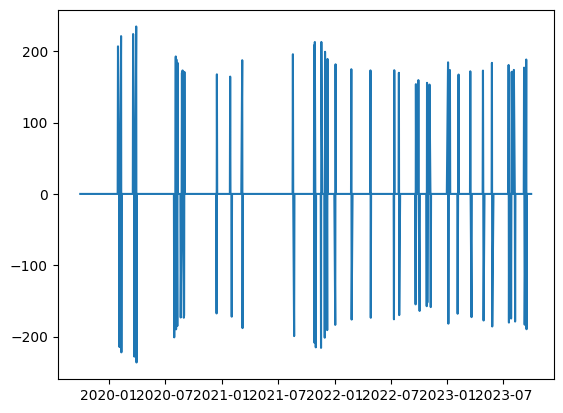

In [355]:
plt.plot(kf_signals['position_AAPL'])

In [323]:
AAPL_cost = kf_signals['position_AAPL'] * kf_signals['raw_AAPL_kf'] * (-1)
MSFT_cost = kf_signals['position_MSFT'] * kf_signals['raw_MSFT_kf'] * (-1)
tot_profit = AAPL_cost.sum() + MSFT_cost.sum()
print(f"Total Profit: {tot_profit}")
kf_signals['daily_position'] = AAPL_cost + MSFT_cost
kf_signals['cum_position'] = (AAPL_cost + MSFT_cost).cumsum()
print(f"Max Asset Daily Decrease: {kf_signals['daily_position'].min()}")
print(f"Max Asset Cumulative Decrease: {kf_signals['cum_position'].min()}")

Total Profit: 16815.52734524379
Max Asset Daily Decrease: -663.814468931334
Max Asset Cumulative Decrease: -0.0


In [324]:
# Naive Long-Short Portfolio
tot_l_s = 100 * ((kf_signals['raw_MSFT_kf'][-1] - kf_signals['raw_MSFT_kf'][0]) + (kf_signals['raw_AAPL_kf'][0] - kf_signals['raw_AAPL_kf'][-1]))
print(f"Naive Long-Short Profit: {tot_l_s}")
profit_daily_chg = ((kf_signals['raw_MSFT_kf'].diff() - kf_signals['raw_AAPL_kf'].diff())[1:]) * 100
profit_cum_chg = profit_daily_chg.cumsum()
print(f"Max Daily Asset Decrease: {profit_daily_chg.min()}")
print(f"Max Cumulative Asset Decrease: {profit_cum_chg.min()}")

Naive Long-Short Profit: 6646.758270263672
Max Daily Asset Decrease: -1605.5023193359375
Max Cumulative Asset Decrease: -535.9294891357422


In [325]:
def max_drawdown(series):
    series = np.array(series)
    peak = np.maximum.accumulate(series)
    drawdown = (series - peak) / peak
    drawdown[np.isnan(drawdown)] = 0
    max_dd = np.min(drawdown)
    
    return max_dd

In [326]:
kf_dd = max_drawdown(kf_signals['cum_position'])
benchmark_dd = max_drawdown(profit_cum_chg)
effect = (kf_dd - benchmark_dd) / benchmark_dd * (-1)
print(f"Max Drawdown of KF Pair Trading: {kf_dd*100}%")
print(f"Max Drawdown of Naive Long-Short Portfolio: {benchmark_dd*100}%")
print(f"KF Pair Trading decreases max drawdown by {effect*100}% compared to the benchmark")

Max Drawdown of KF Pair Trading: -63.4294079644302%
Max Drawdown of Naive Long-Short Portfolio: -409.3140345586959%
KF Pair Trading decreases max drawdown by 84.50348568359817% compared to the benchmark


In [327]:
coin_spread_signals.to_csv("cs_signals.csv", index=False)
kf_signals.to_csv("kf_signals.csv", index=False)

(array([18262.20833333, 18444.16666667, 18628.20833333, 18809.16666667,
        18993.20833333, 19174.16666667, 19358.20833333, 19539.16666667]),
 [Text(18262.208333333332, 0, '2020-01'),
  Text(18444.166666666668, 0, '2020-07'),
  Text(18628.208333333332, 0, '2021-01'),
  Text(18809.166666666668, 0, '2021-07'),
  Text(18993.208333333332, 0, '2022-01'),
  Text(19174.166666666668, 0, '2022-07'),
  Text(19358.208333333332, 0, '2023-01'),
  Text(19539.166666666668, 0, '2023-07')])

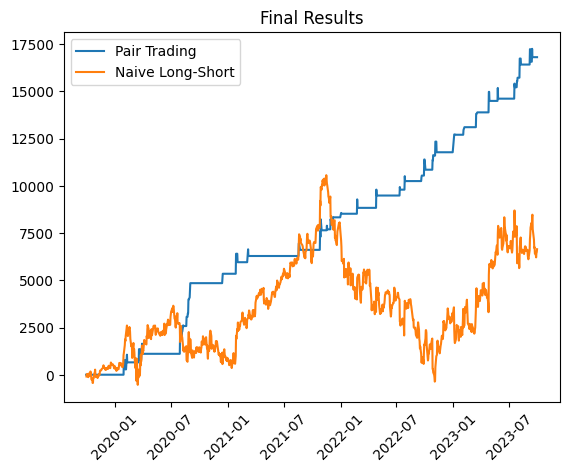

In [329]:
plt.plot(kf_signals['cum_position'], label = "Pair Trading")
plt.plot(profit_cum_chg, label = "Naive Long-Short")
plt.legend()
plt.title("Final Results")
plt.xticks(rotation=45)